In [1]:
import numpy as np
import torch
from torch.utils.data import DataLoader

import sys
sys.path.append('../')

import config
from classfier_cell_state import CellStateClassifier
from classfier_cell_state import TranscriptomicsDataset

import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import numpy as np
import pandas as pd
from sklearn import manifold
import matplotlib.pyplot as plt
from MulticoreTSNE import MulticoreTSNE
import altair as alt
alt.data_transformers.disable_max_rows()

DataTransformerRegistry.enable('default')

In [2]:
@torch.no_grad()
def binary_acc(logits, targets):
    if logits.dim != targets.dim:
        targets = targets.unsqueeze(1)
    y_pred_tag = torch.sigmoid(logits)   
    y_pred_tag_round = torch.round(y_pred_tag)

    correct_results_sum = (y_pred_tag_round == targets).sum().float()
    acc = correct_results_sum / targets.shape[0]
    acc = torch.round(acc * 100)
    return acc, y_pred_tag

In [3]:
network = CellStateClassifier(num_genes=config.genes_per_single_cell)
network.load_state_dict(torch.load("../models/checkpoints/classifier_5kgenes.pth", map_location=torch.device('cpu')))
testset = TranscriptomicsDataset(filepath_data=f"../{config.filepath_test_toy}", device="cuda")
dataloader = DataLoader(testset, batch_size=1, shuffle=False)
network.eval()

data input has size: (3000, 5001)


CellStateClassifier(
  (fc1): Linear(in_features=5000, out_features=10000, bias=True)
  (fc2): Linear(in_features=10000, out_features=2500, bias=True)
  (fc3): Linear(in_features=2500, out_features=1, bias=True)
  (classifier): Sequential(
    (0): Linear(in_features=5000, out_features=10000, bias=True)
    (1): SELU()
    (2): Linear(in_features=10000, out_features=2500, bias=True)
    (3): SELU()
    (4): Linear(in_features=2500, out_features=1, bias=True)
  )
)

In [4]:
device = next(network.parameters()).device
accuracies = []
probs = []
labels = []
for batch_idx, (inputs, targets) in enumerate(dataloader):
    inputs = inputs.to(device)
    targets = targets.to(device)

    logits = network(inputs)
    accuracy_mini_batch, prob = binary_acc(logits, targets)
    accuracies.append(accuracy_mini_batch)
    probs.append(prob)
    labels.append(targets)

In [5]:
probs_tolist = np.array([float(p) for p in probs])

In [6]:
len(probs_tolist)

3000

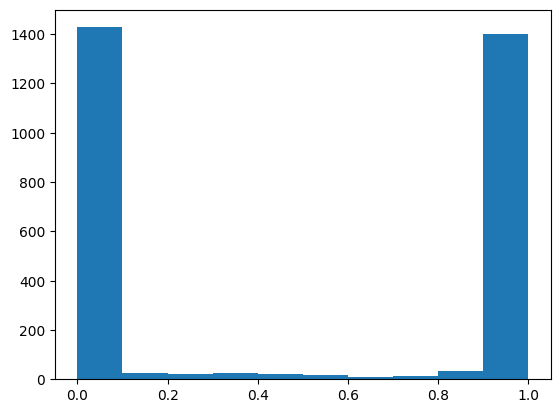

In [7]:
plt.hist(probs_tolist, density=False)
plt.show()

In [8]:
labels_tolist = [int(l) for l in labels]

In [9]:
confusion_matrix(labels_tolist, [int(torch.round(p)) for p in probs])

array([[1469,   38],
       [  52, 1441]])

In [10]:
tn, fp, fn, tp = confusion_matrix(labels_tolist, [int(torch.round(p)) for p in probs]).ravel()
print(tn, fp, fn, tp)

1469 38 52 1441


In [11]:
test = "../data/Tran_RGC_scRNA/npys/toy-data/split-control_and_2w_after_crush_5000x5000_toy/test.npy"
load_test = np.load(test, allow_pickle=True)

In [12]:
load_test

array([[0, 0, 0, ..., 0, 0, 'control'],
       [0, 0, 0, ..., 0, 0, '2w_after_crush'],
       [0, 0, 0, ..., 0, 0, 'control'],
       ...,
       [0, 0, 0, ..., 0, 0, 'control'],
       [0, 0, 1, ..., 0, 0, 'control'],
       [0, 0, 0, ..., 0, 0, 'control']], dtype=object)

In [23]:
df_no_meta = load_test[:,:-1]
tsne_coords_long_time_span = manifold.TSNE(perplexity=50).fit_transform(df_no_meta)

In [24]:
tsne_coords_long_time_span

array([[ -0.2050635,  14.348244 ],
       [-23.01394  ,  22.24618  ],
       [ 16.704315 , -21.46347  ],
       ...,
       [-14.253437 ,  12.178619 ],
       [ 37.324444 , -29.956377 ],
       [-13.795967 ,  39.688835 ]], dtype=float32)

In [25]:
df_tsne_coords_long_time_span = pd.DataFrame(tsne_coords_long_time_span, columns=['X','Y'])
df_tsne_coords_long_time_span.describe()

,X,Y
count,3000.000000,3000.000000
mean,1.671713,-0.212113
std,17.411245,21.888702
min,-28.345577,-42.560940
25%,-13.452682,-17.843272
50%,-1.677128,-3.334717
75%,13.838058,20.925053
max,43.500618,42.584751


In [38]:
probs_round = np.array([torch.round(p) for p in probs])
probs_round

array([1., 0., 1., ..., 1., 1., 1.], dtype=float32)

In [57]:
correct = np.array(labels)==np.array(probs_round)
predictions_for_tsne = np.array(["correctly_classfied" if class_pred else "nope" for class_pred in correct])
print(sum(predictions_for_tsne=="correctly_classfied")), print("tot len",len(predictions_for_tsne))

2910
tot len 3000


(None, None)

In [62]:
sample_type_of_cells = pd.Series(load_test[:,-1])
predicted_labels = pd.Series(predictions_for_tsne)
tsne_with_meta_long_time_span = pd.concat([predicted_labels, sample_type_of_cells, df_tsne_coords_long_time_span], axis='columns')
tsne_with_meta_long_time_span = tsne_with_meta_long_time_span.rename(columns={0:"classification"})
tsne_with_meta_long_time_span = tsne_with_meta_long_time_span.rename(columns={1:"sample_type"})

In [71]:
alt.Chart(tsne_with_meta_long_time_span).mark_point(
    opacity=0.6
).encode(
    x='X',
    y='Y',
    color='sample_type:N',
    # shape='classification',
    size="classification",
).properties(
    width=700,
    height=700,
    title="Neuronal cells projected genes from after day 0, day 4, week 1, and week 2"
).interactive()

alt.Chart(...)

## on the full control and 2 weeks

In [28]:
full_control_2w = "../data/Tran_RGC_scRNA/npys/stacked/control_2w.npy"
load_full_control_2w = np.load(full_control_2w, allow_pickle=True)
df_no_meta_full_control_2w = load_full_control_2w[1:,:-1]

In [ ]:
tsne_coords_full_control_2w = manifold.TSNE(perplexity=15).fit_transform(df_no_meta_full_control_2w)

In [ ]:
df_tsne_coords_full_control_2w = pd.DataFrame(tsne_coords_full_control_2w, columns=['X','Y'])
sample_type_of_cells_full_control_2w = pd.Series(load_full_control_2w[1:,-1])

tsne_with_meta_full_control_2w= pd.concat([sample_type_of_cells_full_control_2w, df_tsne_coords_full_control_2w], axis='columns')
tsne_with_meta_full_control_2w = tsne_with_meta_full_control_2w.rename(columns={0:"sample_type"})

alt.Chart(tsne_with_meta_full_control_2w).mark_point(
    opacity=0.6
).encode(
    x='X',
    y='Y',
    color='sample_type:N',
    shape='sample_type:N'
).properties(
    width=700,
    height=700,
    title="Neuronal cells projected genes from after day 0, and week 2"
).interactive()